## Teste de permutação

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("all_seasons.csv")

Repetindo algumas partes do tratamento de dados já feito durante a análise exploratória...

Abaixo, observamos se há um comportamento tendenciosos entre as universidades e os jogaores draftados

In [3]:
df = df[df['college'] != 'None']
df['drafted'] = df['draft_year'].apply(lambda c: 1 if c!='Undrafted' else 0)

print(df.groupby('college')['drafted'].sum().sort_values()[::-1])

college
North Carolina                258
Kentucky                      250
Duke                          244
UCLA                          219
Arizona                       215
                             ... 
Siena                           0
South Carolina State            0
Miami (Fla.)                    0
Meridian Community College      0
Pfeiffer                        0
Name: drafted, Length: 287, dtype: int64


In [4]:
# removendo dados com nomes iguais, deixando apenas os com as menores seasons / ages
# obtendo a primeira temporada de cada jogador
df = df.loc[df.groupby("player_name")["age"].idxmin()]

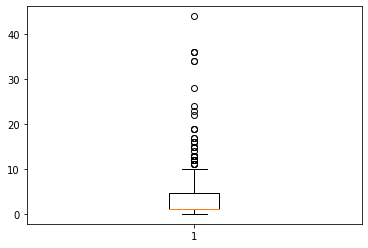

In [5]:
plt.boxplot(df.groupby('college')['drafted'].sum())
plt.show()

Pelo que parece há uma tendencia entre as universidades e a quantidade de jogadores draftados visto que há uma grande quantidade de outliers segundo o boxplot, observando que dentro de um consjunto de 286 universidades, cerca de pouco mais de 30 universidades já enviaram mais de 15 jogaores no total para a NBA

Argumenta-se que um bom jogador participa de um grande número de lances no jogo. Ou seja, o percentual de participação do jogador na partida (usg_pct) é alto. Surge, então, a pergunta, partindo de um conjunto de variáveis sobre um jogador, é possível prever a porcentagem de participação de tal jogador nas partidas?

Primeiro verificamos se existe uma relação entre um jogador ser draftado e ser participativo nas partidas de basquete. Isso é feito com um teste de permutação onde é permutado o parametro "drafted" que indica se tal jogador foi draftado (1) ou não (0). Então plotamos, em um histograma, a diferença entre as médias do parâmetro "usg_pct" para jogadores draftados e não draftados. Dessa forma, é possível observar o comportamento para a média encontrada no dataset e concluir, com um intervalo de confiança, se tal comportamente é aleatório ou não.

In [6]:
teste = df.copy()

t_obs = teste[teste['drafted'] == 1]['usg_pct'].mean() - teste[teste['drafted'] != 1]['usg_pct'].mean()
t_obs

0.011757973007248734

In [7]:
N = 10000
diferencas = np.zeros(N)

for i in range(N):
    np.random.shuffle(teste['drafted'].values)
    diff = teste[teste['drafted'] == 1]['usg_pct'].mean() - teste[teste['drafted'] != 1]['usg_pct'].mean()
    diferencas[i] = diff

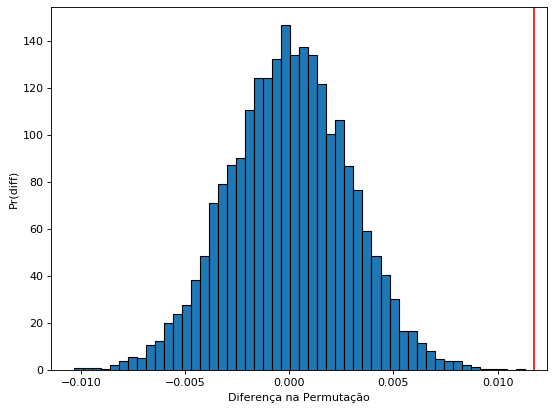

In [8]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.hist(diferencas, bins=50, density=True, edgecolor='k')
plt.xlabel('Diferença na Permutação')
plt.ylabel('Pr(diff)')
plt.axvline(t_obs, color='red', linestyle='solid')
plt.show()

In [9]:
print("Intervalo de confiança: [{}, {}]".format(np.percentile(diferencas, 2.5), np.percentile(diferencas, 97.5)))

Intervalo de confiança: [-0.005626892057601253, 0.005537671422278016]


Observamos que em um mundo aleatório, 95% dos nossos dados ficaria dentro do intervalo acima. No entando, visto que a média observada pelos dados reais, representada pela linha vermelha a direita do gráfico, é maior do que o limite superior do intervalo, podemos afirmar, com 95% de certeza, que o valor observado não apresenta um comportamento aleatório. O que nos motiva ao próximo passo, efetuar uma regressão e traçar um modelo de previsão do parâmetro 'usg_pct'.

## Regressão Linear

Queremos fazer uma regressão linear nos dados baseando-se em 10 atributos de jogadores para tentar prever a participação percentual de um dado jogador em um dado jogo. Assim, conseguimos definir se tal jogador tem um alta probabilidade de ser draftado, pois, como demonstrado, o atributo "usg_pct" é um forte influenciador na classificação de um jogador como "drafted" ou não.

### Análise dos atributos obtidos

Primeiro gostariamos de fazer uma breve análise de relação de cada um dos atributos com o "usg_pct", indicando, assim, se tal atributo possui ou não uma correlação com o atributo o qual estamos tentando prever.

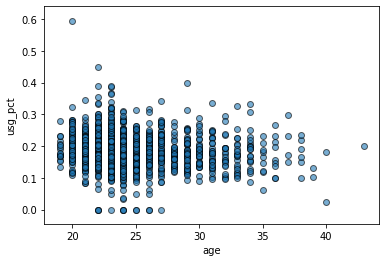

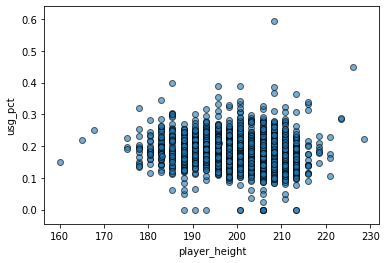

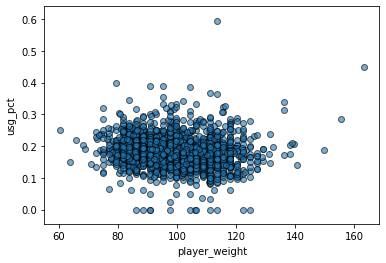

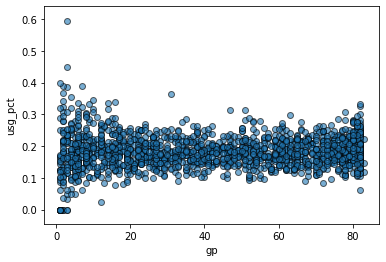

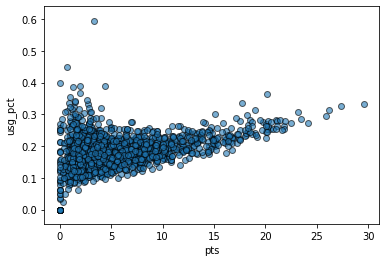

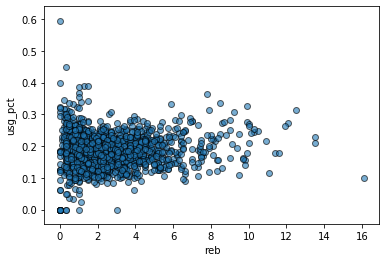

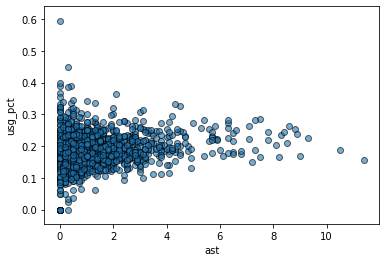

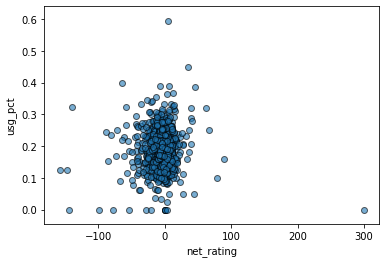

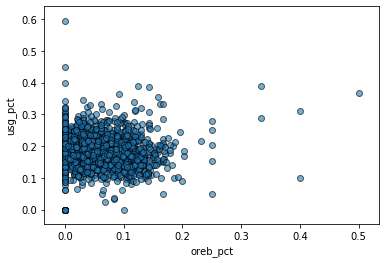

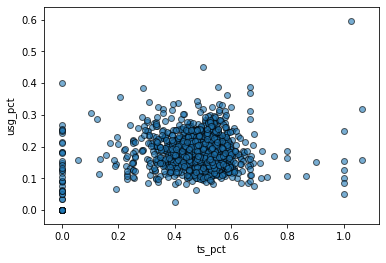

In [10]:
attrs = ['age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'ts_pct']
y = df['usg_pct']
X = df[attrs]

for attr in attrs:
    plt.scatter(X[attr], y, edgecolor='k', alpha=0.6)
    plt.xlabel(attr)
    plt.ylabel('usg_pct')
    plt.show()

### Separação: Teste/Treino

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1315, 10) (1315,)
(329, 10) (329,)


Separamos os dados em treino e teste com uma proporção de 80% para treinoe e 20% para teste.

### Regressão

Text(0, 0.5, 'Predictions')

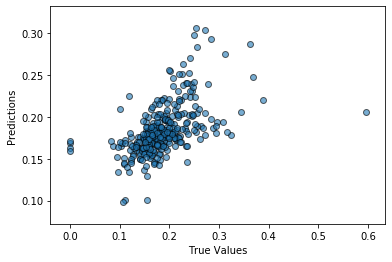

In [14]:
def score(alpha, X_train, Y_train, X_test, Y_test):
    model =  linear_model.Ridge(alpha=alpha)
    model.fit(X_train, Y_train)
    return model.score(X_test, Y_test)

def find_best_alpha(X_train, Y_train, X_test, Y_test):
    alphas =[0.01*(10**i) for i in range(5)]
    return max([(alpha, score(alpha, X_train, Y_train, X_test, Y_test)) for alpha in alphas], key=lambda e:e[1])

alpha, score = find_best_alpha(X_train, y_train, X_test, y_test)

lm = linear_model.Ridge(alpha=alpha)

model = lm.fit(X_train,y_train)
predictions = lm.predict(X_test)

plt.scatter(y_test, predictions, edgecolor='k', alpha=0.6)
plt.xlabel("True Values")
plt.ylabel("Predictions")


Percebe-se uma relação linear das previsões e dos dados verdadeiros de teste.

### Resultados

In [13]:
print("Coeficientes:", model.coef_)
print("Intercept:", model.intercept_)
print("Score (R2):", model.score(X_test, y_test))

Coeficientes: [-1.44971547e-03 -8.08642154e-04  2.75333009e-04 -4.22576031e-04
  1.10633245e-02 -1.06224891e-02 -7.85393229e-03  2.81413793e-05
  1.39997174e-01 -4.02529411e-03]
Intercept: 0.3403031901390493
Score (R2): 0.28768895568771613


Observamos, portanto, que conseguimos sim prever o valor de "usg_pct" baseando-se em diferentes atributos dos jogadores. Isto é feito utlizando uma regressão linear com regularização de Ridge, onde o parametro "alpha" foi escolhido de tal forma a maximizar o Score, ou R2, achando assim, um modelo que melhor se ajusta aos dados sem comprometer a variância.